# Pylops - Seismic interpolation with directional filters

### Author: M.Ravasi

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from scipy.signal import triang
from scipy.ndimage import median_filter

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing           import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import *
from pylops.utils.signalprocessing     import slope_estimate

from pylops.config import set_ndarray_multiplication

In [2]:
np.random.seed(10)

## Data creation

In [3]:
###### Input parameters
par = {'ox':-700, 'dx':10, 'nx':141,
       'oy':-500, 'dy':10, 'ny':101,
       'ot':0, 'dt':0.004,'nt':201,
       'f0':20}

nt, dt = par['nt'], par['dt']
nr, dx = par['nx'], par['dx']

v = dx / dt # normalizes x and y axis and the angle of linear ever is effectively theta
t0    = np.array([0.1, 0.3, 0.6, 0.4])
angle = 30

# constant (can use analytical slopes)
#theta = np.array([angle, angle, angle, angle])
# variable (needs numerical slopes) 
theta = np.array([angle, angle+10, angle-20, angle-60])

# apply conversion as slope is computed based on y=px * x + y0 with px=tan(theta)
theta = np.rad2deg((np.arcsin(np.tan(np.deg2rad(theta)))))
phi   = np.array([0, 0, 0, 0])
amp   = np.array([1., -1, 1, 0.6])

# Create axis
taxis, taxis2, xaxis, yaxis = makeaxis(par)

# Create wavelet
wav = ricker(taxis[:41], f0=par['f0'])[0]

# Generate model
ds, d =  linear2d(xaxis, taxis, v, t0, theta, amp, wav)
d = d.T
ds = ds.T

print(theta)

[ 35.26438968  57.04516467  10.15588943 -35.26438968]


In [4]:
nfft_f = nfft_k = 2**10
F = FFT2D(dims=(nt, nr), nffts=(nfft_f, nfft_k), sampling=[par['dt'], par['dx']], dtype=np.float)

D = F * d.ravel()
dadj = F.H * D

D = D.reshape(nfft_f, nfft_k)

/var/folders/pc/wf4mhn4n2cv8wjt_jtj8t8qhsljrkk/T/ipykernel_34250/1390156139.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  F = FFT2D(dims=(nt, nr), nffts=(nfft_f, nfft_k), sampling=[par['dt'], par['dx']], dtype=np.float)


## Compute derivative data

In [5]:
ks = np.fft.fftfreq(nfft_k, dx)
f = np.fft.fftfreq(nfft_f, dt)

coeff1 = 1j*2*np.pi*ks
coeff1_m = np.tile(coeff1[:, np.newaxis], nfft_f).T

D1op_hand = Diagonal(coeff1_m.ravel())
D1 = D1op_hand * D.ravel()

d1 = F.H * D1
d1 = d1.reshape(nt, nr)

sc1 = np.max(np.abs(d)) / np.max(np.abs(d1))
print(sc1)

18.24977054610779


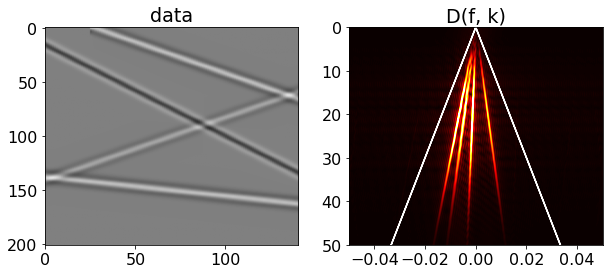

In [6]:
v = 1500 # water velocity

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(d, cmap='gray', aspect='auto', vmin=-2, vmax=2)
axs[0].set_title('data')
axs[1].imshow(np.abs(np.fft.fftshift(D.reshape(nfft_f, nfft_k)))[nfft_f//2:], 
              cmap='hot', aspect='auto', vmin=0, vmax=5e-1, 
              extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nfft_f//2-1], f[0]))
axs[1].plot(f/v, f,'w'), axs[1].plot(f/v, -f,'w')
axs[1].set_title('D(f, k)')
axs[1].set_xlim(-1/(2*dx), 1/(2*dx));
axs[1].set_ylim(50, 0);

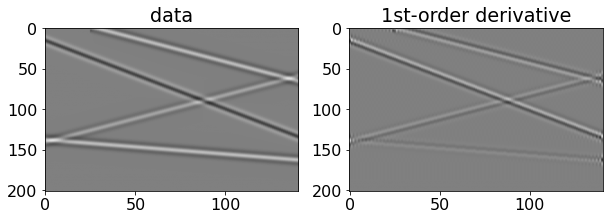

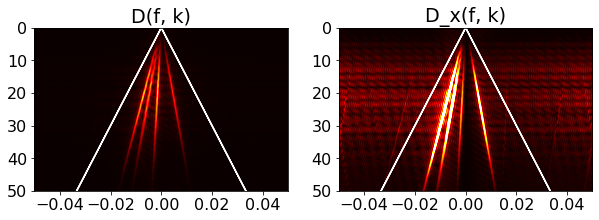

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].imshow(d, cmap='gray', aspect='auto', vmin=-2, vmax=2)
axs[0].set_title('data')
axs[1].imshow(sc1 * d1, cmap='gray', aspect='auto', vmin=-2, vmax=2)
axs[1].set_title('1st-order derivative')

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].imshow(np.abs(np.fft.fftshift(D.reshape(nfft_f, nfft_k)))[nfft_f//2:], 
              cmap='hot', aspect='auto', vmin=0, vmax=1e0, 
              extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nfft_f//2-1], f[0]))
axs[0].plot(f/v, f,'w'), axs[0].plot(f/v, -f,'w')
axs[0].set_xlim(-1/(2*dx), 1/(2*dx));
axs[0].set_ylim(50, 0)
axs[0].set_title('D(f, k)')
axs[1].imshow(np.abs(np.fft.fftshift(D1.reshape(nfft_f, nfft_k)))[nfft_f//2:], 
              cmap='hot', aspect='auto', vmin=0, vmax=1e-2, 
              extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nfft_f//2-1], f[0]))
axs[1].plot(f/v, f,'w'), axs[1].plot(f/v, -f,'w')
axs[1].set_xlim(-1/(2*dx), 1/(2*dx));
axs[1].set_ylim(50, 0)
axs[1].set_title('D_x(f, k)');

## Compute f-k mask

/var/folders/pc/wf4mhn4n2cv8wjt_jtj8t8qhsljrkk/T/ipykernel_34250/433914948.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = mask.astype(np.int)


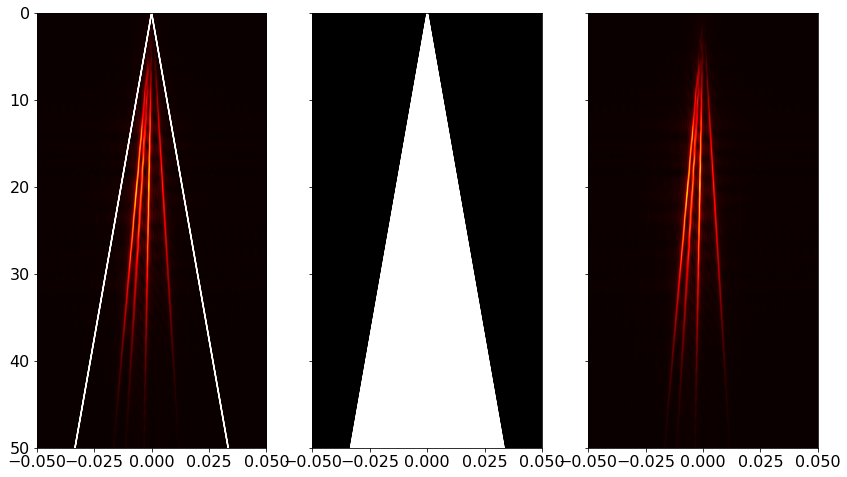

In [8]:
critical = 1.00
koffset = 0.000
vel = 1500.
fmax = 55

fmask = np.zeros(nfft_f)
fmask[np.abs(f)<fmax] = 1

[kx, ff] = np.meshgrid(ks, f, indexing='ij')
mask = np.abs(kx) < (critical*np.abs(ff)/vel + koffset)
mask = mask.T
mask *= fmask[:, np.newaxis].astype(bool)
mask = mask.astype(np.int)

fig,axes = plt.subplots(1, 3, sharey=True, figsize=(14, 8))
axes[0].imshow(np.fft.fftshift(np.abs(D)), cmap='hot',aspect='auto', vmin=0, vmax=1e0,
               extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], 
                       np.fft.fftshift(f)[-1], np.fft.fftshift(f)[0]))
axes[0].plot(f/v, f,'w'), axes[0].plot(f/v, -f,'w')
axes[0].set_xlim(-1/(2*dx), 1/(2*dx))
axes[1].imshow(np.fft.ifftshift(mask), cmap='gray', aspect='auto',
               extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], 
                       np.fft.fftshift(f)[-1], np.fft.fftshift(f)[0]))
axes[1].plot(f/v, f,'w'), axes[1].plot(f/v, -f,'w')
axes[1].set_xlim(-1/(2*dx), 1/(2*dx))
axes[2].imshow(np.fft.fftshift((1-np.fft.ifftshift(mask))*np.abs(D)), cmap='hot', aspect='auto', 
               vmin=0, vmax=1e0,
               extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], 
                       np.fft.fftshift(f)[-1], np.fft.fftshift(f)[0]));
axes[2].set_xlim(-1/(2*dx), 1/(2*dx))
axes[2].set_ylim(50, 0);

## Slope estimation

In [9]:
from scipy.ndimage import gaussian_filter

def slope_estimate1(d, dz, dx, smooth=20, paralleldir=True):
    """Estimate local slopes and linearity using 
    Structure Tensor algorithm (Van Vliet and Verbeek, 1995)
    """
    nz, nx = d.shape
    gz, gx = np.gradient(d, dz, dx)
    gzz, gzx, gxx = gz*gz, gz*gx, gx*gx

    # smoothing
    gzz = gaussian_filter(gzz, sigma=smooth)
    gzx = gaussian_filter(gzx, sigma=smooth)
    gxx = gaussian_filter(gxx, sigma=smooth)

    dirs = np.zeros((2, nz, nx))
    eigs = np.zeros((2, nz, nx))
    slopes = np.zeros((nz, nx))
    linearity = np.zeros((nz, nx))
    for iz in range(nz):
        for ix in range(nx):
            T = np.array([[gzz[iz, ix], gzx[iz, ix]],
                          [gzx[iz, ix], gxx[iz, ix]]])
            E, U = np.linalg.eig(T)
            eigs[:, iz, ix] = E
            u = U[np.argmax(E)] # eigenvector of min variation/ max coherency (parallel to feature)
            v = U[np.argmin(E)] # eigenvector of max variation/ min coherency (orthogonal to feature)
            # should be opposite!!
            if paralleldir:
                dirs[:, iz, ix] = u
            else:
                dirs[:, iz, ix] = v
            slopes[iz, ix] = np.arctan(v[0]/v[1])#np.angle(v[1] + 1j*v[0])
            linearity[iz, ix] = (np.max(E) - np.min(E))/np.max(E) 
    return slopes, linearity, dirs, eigs

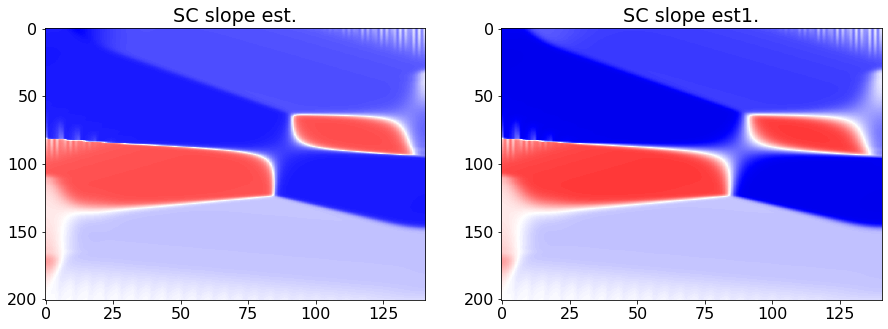

In [10]:
# Single component slope
slope_sc, linearity, dirs_parallel, eigs = slope_estimate1(d, 1, 1, smooth=5, paralleldir=True)
dirs_normal = slope_estimate1(d, 1, 1, smooth=5, paralleldir=False)[2]

slope_sc1 = slope_estimate(d, dt, dx, smooth=5)[0]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(np.rad2deg(slope_sc), vmin=-90, vmax=90, cmap='seismic')
axs[0].set_title('SC slope est.')
axs[0].axis('tight')
axs[1].imshow(np.rad2deg(slope_sc1) * dx / dt, vmin=-90, vmax=90, cmap='seismic')
axs[1].set_title('SC slope est1.')
axs[1].axis('tight');

## Interpolation

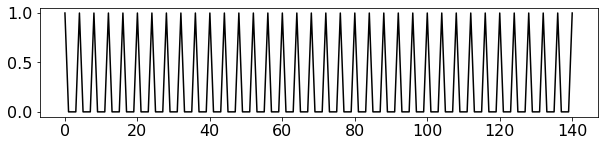

In [11]:
# irregular subsampling
#perc_subsampling = 0.1
#Nsub=int(np.round(par['nx']*perc_subsampling))
#iava = np.sort(np.random.permutation(np.arange(par['nx']))[:Nsub])

# regular subsampling
sub = 4
iava = np.arange(par['nx'])[::sub]
Nsub = len(iava)
ava = np.zeros(par['nx'])
ava[iava] = 1
plt.figure(figsize=(10, 2))
plt.plot(ava, 'k')

# Create restriction operator
Rop = Restriction((par['nx'], par['nt']), iava, axis=0, inplace=False, dtype='float64')

x = d.T
y = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nt'])
xadj = xadj.reshape(par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

/var/folders/pc/wf4mhn4n2cv8wjt_jtj8t8qhsljrkk/T/ipykernel_34250/4118676724.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Mf = Diagonal(mask.T.astype(np.int))
/opt/anaconda3/envs/pylops/lib/python3.9/site-packages/numpy/lib/shape_base.py:260: ComplexWarning: Casting complex values to real discards the imaginary part
  arr[_make_along_axis_idx(arr_shape, indices, axis)] = values


FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 7236 rows and 1048576 cols
eps = 1.000000e-02	tol = 1.000000e-10	niter = 20
alpha = 1.333373e+00	thresh = 6.666865e-03
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   0.00e+00+0.00e+00j    8.659e+01   1.063e+02   1.334e+01
     2   0.00e+00+0.00e+00j    4.138e+01   7.127e+01   8.064e+00
     3   0.00e+00+0.00e+00j    1.687e+01   5.408e+01   6.727e+00
     4   0.00e+00+0.00e+00j    6.177e+00   4.790e+01   4.991e+00
     5   0.00e+00+0.00e+00j    2.500e+00   4.645e+01   3.306e+00
     6   0.00e+00+0.00e+00j    1.517e+00   4.604e+01   2.033e+00
     7   0.00e+00+0.00e+00j    1.300e+00   4.538e+01   1.402e+00
     8   0.00e+00+0.00e+00j    1.283e+00   4.442e+01   1.291e+00
     9   0.00e+00+0.00e+00j    1.349e+00   4.343e+01   1.301e+00
    10   0.00e+00+0.00e

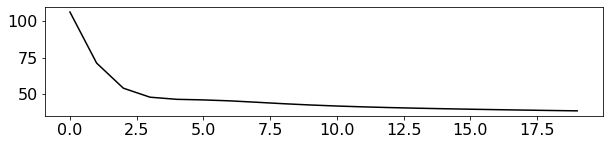

In [12]:
set_ndarray_multiplication(False)

# FFT of full data
FFTop = FFT2D(dims=[par['nx'], par['nt']], nffts=[nfft_k, nfft_f], sampling=[par['dx'], par['dt']])
X = FFTop * x.flatten()
X = np.reshape(X, (nfft_k, nfft_f))
Y = FFTop * ymask.flatten()
Y = np.reshape(Y, (nfft_k, nfft_f))

Mf = Diagonal(mask.T.astype(np.int))

# Inverse with FISTA
SIop = Rop * FFTop.H * Mf
Xinv, _, cost = fista(SIop, y.ravel(), niter=20, alpha = 1.333373e+00, eps=1e-2, show=True)
#Xinv, _, cost = fista(SIop, y.ravel(), niter=50, threshkind='half-percentile', perc=2, show=True)
xinv = (FFTop.H * Mf * Xinv).real

Xinv = Xinv.reshape(nfft_k, nfft_f)
xinv = xinv.reshape(par['nx'], par['nt'])

plt.figure(figsize=(10, 2))
plt.plot(cost, 'k')

print(np.linalg.norm(x-xinv))

set_ndarray_multiplication(True)

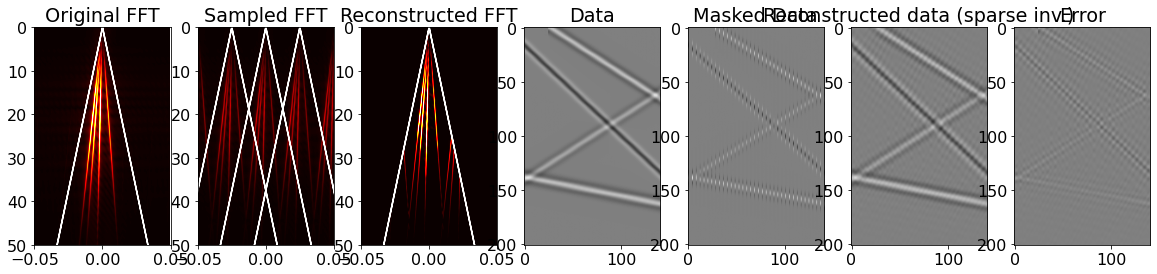

In [13]:
fig, axs = plt.subplots(1, 7, figsize=(20, 4))
axs[0].imshow(np.fft.fftshift(np.abs(X[:, :nfft_f//2-1]),axes=0).T, 
              cmap='hot', aspect='auto', vmin=0, vmax=5e-1, 
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft_f//2-1], FFTop.f2[0]))
axs[0].plot(f/v, f,'w'), axs[0].plot(f/v, -f,'w')
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_xlim(-1/(2*dx), 1/(2*dx))
axs[0].set_ylim(50, 0)
axs[1].imshow(np.fft.fftshift(np.abs(Y[:, :nfft_f//2-1]),axes=0).T,
              cmap='hot', aspect='auto', vmin=0, vmax=5e-1, 
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft_f//2-1], FFTop.f2[0]))
axs[1].plot(f/v, f,'w'), axs[1].plot(f/v, -f,'w')
axs[1].plot(f/v - 1./(sub*dx), f,'w'), axs[1].plot(f/v + 1./(sub*dx), -f,'w')
axs[1].plot(-f/v - 1./(sub*dx), f,'w'), axs[1].plot(-f/v + 1./(sub*dx), -f,'w')
axs[1].set_title('Sampled FFT')
axs[1].axis('tight')
axs[1].set_xlim(-1/(2*dx), 1/(2*dx))
axs[1].set_ylim(50, 0)
axs[2].imshow(np.fft.fftshift(np.abs(Xinv[:, :nfft_f//2-1]),axes=0).T,
              cmap='hot', aspect='auto', vmin=0, vmax=5e-1, 
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft_f//2-1], FFTop.f2[0]))
axs[2].plot(f/v, f,'w'), axs[2].plot(f/v, -f,'w')
axs[2].set_title('Reconstructed FFT')
axs[2].axis('tight')
axs[2].set_xlim(-1/(2*dx), 1/(2*dx))
axs[2].set_ylim(50, 0)
axs[3].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Data')
axs[3].axis('tight');
axs[4].imshow(ymask.data.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Masked Data')
axs[4].axis('tight');
axs[5].imshow(xinv.T, cmap='gray', vmin=-2, vmax=2)
axs[5].set_title('Reconstructed data (sparse inv.)')
axs[5].axis('tight');
axs[6].imshow(x.T - xinv.T, cmap='gray', vmin=-2, vmax=2)
axs[6].set_title('Error')
axs[6].axis('tight');

## Interpolation with directional filters

$$
\begin{bmatrix}
    \mathbf{y} \\
    \mathbf{0}
\end{bmatrix} = \begin{bmatrix}
    \mathbf{R} \\
    \epsilon \mathbf{D_{||}}
\end{bmatrix} \mathbf{S}^H \mathbf{x}
$$

where $\mathbf{S}$ is a sparsifying transform and $\mathbf{D_{||}}$ is a directional derivative along the direction of minimum variation (i.e., parallel to the wavefront) to enforce continuity in the solution.

In [14]:
if len(np.unique(theta)) == 1:
    dirs_parallel_ana = np.vstack((np.cos(np.deg2rad(angle))*np.ones((1, nt, nr)), 
                               np.sin(np.deg2rad(angle))*np.ones((1, nt, nr))))
    dirs_normal_ana = np.vstack((-np.sin(np.deg2rad(angle))*np.ones((1, nt, nr)), 
                                 np.cos(np.deg2rad(angle))*np.ones((1, nt, nr))))
    jump = 20
    fig, ax = plt.subplots(figsize=(10, 7))
    im = ax.imshow(d, cmap='gray',  vmin=-1, vmax=1,
                   extent = (0, xaxis[::jump].size, taxis[::jump].size, 0))
    q = ax.quiver(dirs_parallel_ana[0, ::jump, ::jump], 
                  -dirs_parallel_ana[1, ::jump, ::jump], color='r', scale=jump/2)
    q = ax.quiver(dirs_normal_ana[0, ::jump, ::jump], 
                  -dirs_normal_ana[1, ::jump, ::jump], color='w', scale=jump/2)
    ax.set_title('Data with analytical directions')
    plt.colorbar(im, ax=ax);

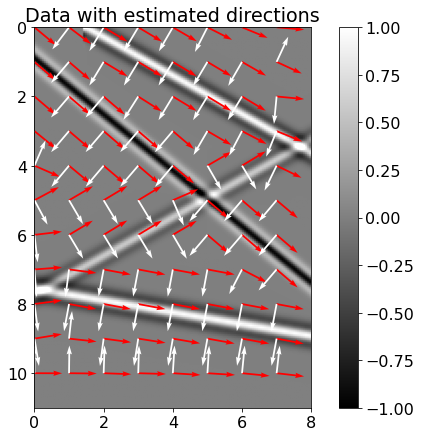

In [15]:
jump = 20
fig, ax = plt.subplots(figsize=(10, 7))
im = ax.imshow(d, cmap='gray',  vmin=-1, vmax=1,
               extent = (0, xaxis[::jump].size, taxis[::jump].size, 0))
q = ax.quiver(dirs_parallel[0, ::jump, ::jump], 
              -dirs_parallel[1, ::jump, ::jump], color='r', scale=jump/2)
q = ax.quiver(dirs_normal[0, ::jump, ::jump], 
              -dirs_normal[1, ::jump, ::jump], color='w', scale=jump/2)
ax.set_title('Data with estimated directions')
plt.colorbar(im, ax=ax);

In [16]:
if len(np.unique(theta)) == 1:
    Dnop_ana = FirstDirectionalDerivative((nr, nt), v=dirs_normal_ana.transpose(0, 2, 1), dtype='float64')
    Dpop_ana = FirstDirectionalDerivative((nr, nt), v=dirs_parallel_ana.transpose(0, 2, 1), dtype='float64')

    xp_ana = Dpop_ana * x.ravel()
    xp_ana = xp_ana.reshape(nr, nt)
    xn_ana = Dnop_ana * x.ravel()
    xn_ana = xn_ana.reshape(nr, nt)

    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    axs[0].imshow(x.T, cmap='gray', aspect='auto', vmin=-2, vmax=2)
    axs[0].set_title('Data')
    axs[1].imshow(xp_ana.T, cmap='gray', aspect='auto', vmin=-2, vmax=2)
    axs[1].set_title('Parallel derivative')
    axs[2].imshow(xn_ana.T, cmap='gray', aspect='auto', vmin=-2, vmax=2)
    axs[2].set_title('Normal derivative');

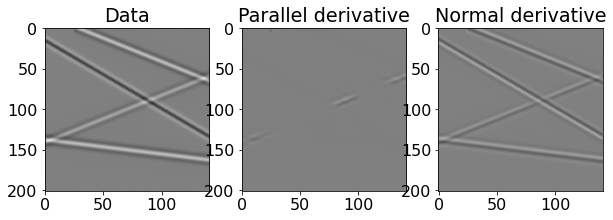

In [17]:
Dnop = FirstDirectionalDerivative((nr, nt), v=dirs_normal.transpose(0, 2, 1), dtype='float64')
Dpop = FirstDirectionalDerivative((nr, nt), v=dirs_parallel.transpose(0, 2, 1), dtype='float64')

xp = Dpop * x.ravel()
xp = xp.reshape(nr, nt)
xn = Dnop * x.ravel()
xn = xn.reshape(nr, nt)

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].imshow(x.T, cmap='gray', aspect='auto', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[1].imshow(xp.T, cmap='gray', aspect='auto', vmin=-2, vmax=2)
axs[1].set_title('Parallel derivative')
axs[2].imshow(xn.T, cmap='gray', aspect='auto', vmin=-2, vmax=2)
axs[2].set_title('Normal derivative');

/Users/ravasim/Desktop/KAUST/OpenSource/pylops/pylops/basicoperators/vstack.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  y[self.nnops[iop] : self.nnops[iop + 1]] = oper.matvec(x).squeeze()
/Users/ravasim/Desktop/KAUST/OpenSource/pylops/pylops/basicoperators/firstderivative.py:153: ComplexWarning: Casting complex values to real discards the imaginary part
  y[..., 1:-1] = 0.5 * (x[..., 2:] - x[..., :-2])


FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 35577 rows and 1048576 cols
eps = 1.000000e-02	tol = 1.000000e-10	niter = 20
alpha = 4.488083e-01	thresh = 2.244041e-03
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   0.00e+00+0.00e+00j    1.586e+02   1.653e+02   4.490e+00
     2   0.00e+00+0.00e+00j    1.278e+02   1.393e+02   3.693e+00
     3   0.00e+00+0.00e+00j    9.770e+01   1.144e+02   4.134e+00
     4   0.00e+00+0.00e+00j    7.088e+01   9.279e+01   4.337e+00
     5   0.00e+00+0.00e+00j    4.888e+01   7.578e+01   4.312e+00
     6   0.00e+00+0.00e+00j    3.225e+01   6.375e+01   4.091e+00
     7   0.00e+00+0.00e+00j    2.067e+01   5.622e+01   3.717e+00
     8   0.00e+00+0.00e+00j    1.328e+01   5.222e+01   3.238e+00
     9   0.00e+00+0.00e+00j    8.998e+00   5.061e+01   2.704e+00
    10   0.00e+00+0.00

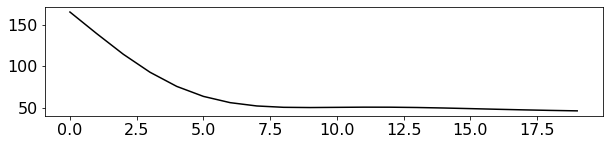

In [18]:
set_ndarray_multiplication(False)

eps_dir = 1e0

# Inverse with FISTA
SIop = VStack([Rop, eps_dir*Dpop]) * FFTop.H * Mf
y1 = np.hstack([y.ravel(), np.zeros(nt*nr)])

#Xinv = lsqr(SIop, y1, iter_lim=20, damp=1e-5, show=True)[0]
Xinv, _, cost = fista(SIop, y1.ravel(), niter=20, eps=1e-2, eigsdict=dict(tol=1e-1), show=True)
#Xinv, _, cost = fista(SIop, y1.ravel(), niter=50, threshkind='half-percentile', 
#                       perc=2, show=True)
Xinv = Mf * Xinv
xinv = (FFTop.H * Mf * Xinv).real

Xinv = Xinv.reshape(nfft_k, nfft_f)
xinv = xinv.reshape(par['nx'], par['nt'])

plt.figure(figsize=(10, 2))
plt.plot(cost, 'k')

print(np.linalg.norm(x-xinv))

set_ndarray_multiplication(True)

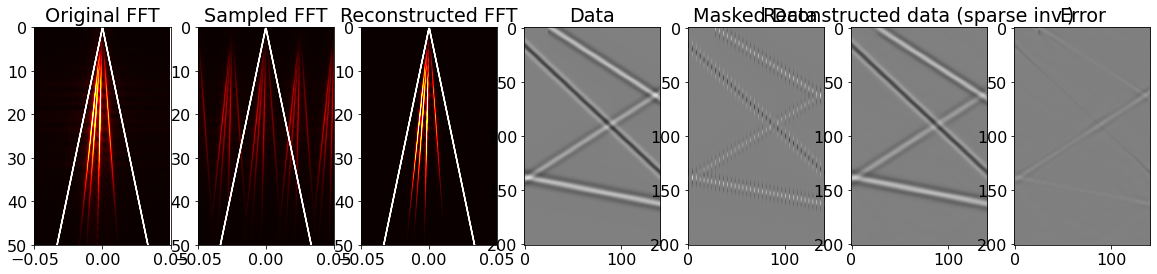

In [19]:
fig, axs = plt.subplots(1, 7, figsize=(20, 4))
axs[0].imshow(np.fft.fftshift(np.abs(X[:, :nfft_f//2-1]),axes=0).T, 
              cmap='hot', aspect='auto', vmin=0, vmax=5e-1, 
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft_f//2-1], FFTop.f2[0]))
axs[0].plot(f/v, f,'w'), axs[0].plot(f/v, -f,'w')
#axs[0].plot(f/v - 1./(2*sub*dx), f,'w'), axs[0].plot(f/v + 1./(2*sub*dx), -f,'w')
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_xlim(-1/(2*dx), 1/(2*dx))
axs[0].set_ylim(50, 0)
axs[1].imshow(np.fft.fftshift(np.abs(Y[:, :nfft_f//2-1]),axes=0).T,
              cmap='hot', aspect='auto', vmin=0, vmax=5e-1, 
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft_f//2-1], FFTop.f2[0]))
axs[1].plot(f/v, f,'w'), axs[1].plot(f/v, -f,'w')
#axs[1].plot(f/v - 1./(2*sub*dx), f,'w'), axs[1].plot(f/v + 1./(2*sub*dx), -f,'w')
axs[1].set_title('Sampled FFT')
axs[1].axis('tight')
axs[1].set_xlim(-1/(2*dx), 1/(2*dx))
axs[1].set_ylim(50, 0)
axs[2].imshow(np.fft.fftshift(np.abs(Xinv[:, :nfft_f//2-1]),axes=0).T,
              cmap='hot', aspect='auto', vmin=0, vmax=5e-1, 
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft_f//2-1], FFTop.f2[0]))
axs[2].plot(f/v, f,'w'), axs[2].plot(f/v, -f,'w')
axs[2].set_title('Reconstructed FFT')
axs[2].axis('tight')
axs[2].set_xlim(-1/(2*dx), 1/(2*dx))
axs[2].set_ylim(50, 0)
axs[3].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Data')
axs[3].axis('tight');
axs[4].imshow(ymask.data.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Masked Data')
axs[4].axis('tight');
axs[5].imshow(xinv.T, cmap='gray', vmin=-2, vmax=2)
axs[5].set_title('Reconstructed data (sparse inv.)')
axs[5].axis('tight');
axs[6].imshow(x.T-xinv.T, cmap='gray', vmin=-2, vmax=2)
axs[6].set_title('Error')
axs[6].axis('tight');

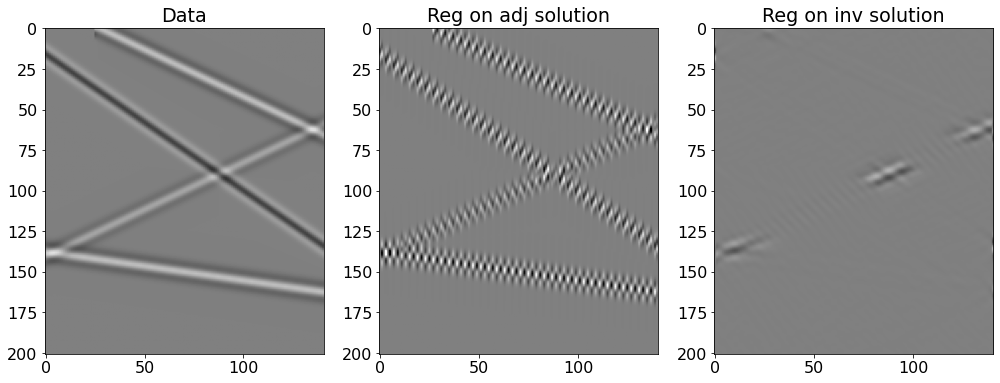

In [20]:
reg_adj = Dpop * ymask.data.ravel()
reg_inv = Dpop * xinv.ravel()
reg_adj = reg_adj.reshape(par['nx'], par['nt'])
reg_inv = reg_inv.reshape(par['nx'], par['nt'])

fig, axs = plt.subplots(1, 3, figsize=(17, 6))
axs[0].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(reg_adj.T, cmap='gray', vmin=-0.5, vmax=0.5)
axs[1].set_title('Reg on adj solution')
axs[1].axis('tight')
axs[2].imshow(reg_inv.T, cmap='gray', vmin=-0.5, vmax=0.5)
axs[2].set_title('Reg on inv solution')
axs[2].axis('tight');